In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
from scipy.stats import zscore


plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
normalize = True

In [3]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=10**6),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=10**6)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [4]:
w_gen = datasets['Pythia26']['gen_widths'] #gen = particle level
w_sim = datasets['Pythia26']['sim_widths'] #sim = detector level
w_truth = datasets['Herwig']['gen_widths']
w_data = datasets['Herwig']['sim_widths']

p_gen = datasets['Pythia26']['gen_jets'][:,0] #gen = particle level
p_sim = datasets['Pythia26']['sim_jets'][:,0] #sim = detector level
p_truth = datasets['Herwig']['gen_jets'][:,0]
p_data = datasets['Herwig']['sim_jets'][:,0]


if normalize:   
    wm = np.mean(w_truth)
    ws = np.std(w_truth)
    pm = np.mean(p_truth)
    ps = np.mean(p_truth)
    
    w_gen = (w_gen - wm)/ws
    w_sim = (w_sim - wm)/ws
    w_truth = (w_truth - wm)/ws
    w_data = (w_data - wm)/ws
    
    p_gen = (p_gen - pm)/ps
    p_sim = (p_sim - pm)/ps
    p_truth = (p_truth - pm)/ps
    p_data = (p_data - pm)/ps

In [5]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.m0 = self.add_weight(name='m0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.m1 = self.add_weight(name='m1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v0 = self.add_weight(name='v0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v1 = self.add_weight(name='v1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y = tf.exp((self.m0 + self.m1*x[:, 0]) * x[:,1] + (self.v0 + self.v1*x[:,0]) * x[:,1]**2)
        return tf.reshape(y, (len(x), 1))

In [6]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [7]:
myc = 0.1


mymodel_inputtest = Input(shape=(2,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((2, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimintor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimintor.compile(loss=weighted_binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    
model_discrimintor.trainable = False
mymodel_gan = Input(shape=(2,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimintor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [8]:
xvals_particle = np.transpose([np.concatenate([w_gen,w_truth]), np.concatenate([p_gen,p_truth])])
xvals_detector = np.transpose([np.concatenate([w_sim,w_data]), np.concatenate([p_sim,p_data])])                        
yvals = np.transpose(np.concatenate([np.ones(len(w_gen)),np.zeros(len(w_truth))]))

X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals)

In [9]:
n_epochs = 3
n_batch = 128*10
n_batches = len(X_train_particle) // n_batch

for i in range(n_epochs):
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch_particle = X_train_particle[j*n_batch:(j+1)*n_batch]
        X_batch_detector = X_train_detector[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==1] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimintor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],Y_batch[Y_batch==0])
    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=", i, mylambda.T)

on epoch= 0 [[ 0.01287149  0.03872611  0.00458098 -0.04414537]]
on epoch= 1 [[ 0.03360247  0.1059825  -0.0566973  -0.13053459]]
on epoch= 2 [[ 0.06470773  0.11671927 -0.10915425 -0.17040762]]


In [10]:
arr = np.exp(np.array((mylambda[0] + mylambda[1]*p_gen) * w_gen + (mylambda[2] + mylambda[3]*p_gen) * w_gen**2))
weights = np.concatenate([np.ones(len(w_gen)), arr*len(w_gen)/np.sum(arr)])
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals, weights)

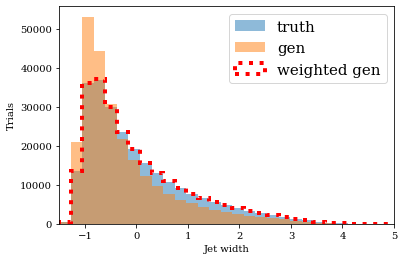

In [109]:
nbins = 30
b_min = -1.5
b_max = 5
_,_,_=plt.hist(X_test_particle[Y_test==0][:,0],bins=np.linspace(b_min,b_max,nbins),alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_particle[Y_test==1][:,0],bins=np.linspace(b_min, b_max,nbins),alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_particle[Y_test==0][:,0],bins=np.linspace(b_min,b_max,nbins),weights=w_test[Y_test==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.xlim(b_min, b_max)
plt.savefig("pjetexample.pdf", bbox_inches='tight', transparent=True)

In [12]:
print(np.mean(X_test_particle[Y_test==0][:,0]),np.mean(X_test_particle[Y_test==1][:,0]),np.average(X_test_particle[Y_test==0][:,0],weights=w_test[Y_test==0]))
print(np.mean(X_test_particle[Y_test==0][:,0]**2),np.mean(X_test_particle[Y_test==1][:,0]**2),np.average(X_test_particle[Y_test==0][:,0]**2,weights=w_test[Y_test==0]))

0.0010116194227035408 -0.25203800331122966 0.0005790436736976696
1.0018884221422786 0.8659207758845179 1.0018253645299966


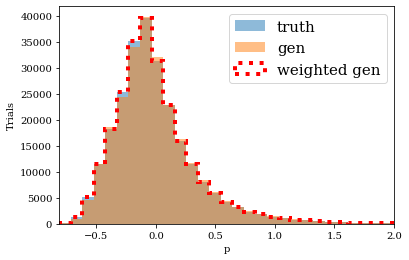

In [13]:
nbins = 30
min = np.min(X_test_particle[Y_test==0][:,1])
max = 2
t,p_bins,_=plt.hist(X_test_particle[Y_test==0][:,1],bins=np.linspace(min,max,nbins),alpha=0.5,label="truth")
g,_,_=plt.hist(X_test_particle[Y_test==1][:,1],bins=np.linspace(min, max,nbins),alpha=0.5,label="gen")
wg,_,_=plt.hist(X_test_particle[Y_test==0][:,1],bins=np.linspace(min,max,nbins),weights=w_test[Y_test==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("p")
plt.ylabel("Trials")
plt.xlim(min, max)
plt.savefig("jetexample.pdf", bbox_inches='tight', transparent=True)

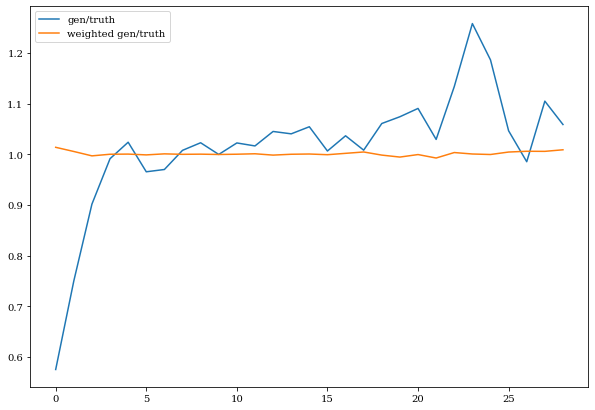

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(g/(t+10**-5), label = "gen/truth")
plt.plot(wg/(t+10**-5), label= "weighted gen/truth")
plt.legend()
plt.show()

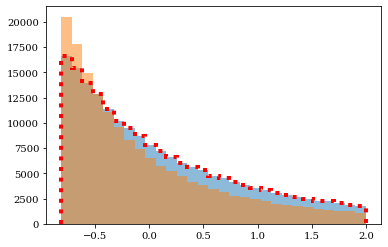

In [16]:
_,_,_=plt.hist(X_test_particle[Y_test==0][:,0],bins=p_bins,alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_particle[Y_test==1][:,0],bins=p_bins,alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_particle[Y_test==0][:,0],bins=p_bins,weights=w_test[Y_test==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")

In [93]:
pTbins_t = np.digitize(X_test_particle[Y_test==0][:,1],p_bins)
pTbins_g = np.digitize(X_test_particle[Y_test==1][:,1],p_bins)
pTbins_wg = np.digitize(X_test_particle[Y_test==0][:,1],p_bins)


w_avgs_t = [np.mean(X_test_particle[Y_test==0][:,0][pTbins_t==i]) for i in range(1, len(p_bins)-1)]
w_avgs_g = [np.mean(X_test_particle[Y_test==1][:,0][pTbins_g==i]) for i in range(1, len(p_bins)-1)]
w_avgs_wg = [np.average(X_test_particle[Y_test==0][:,0][pTbins_wg==i], weights = w_test[Y_test==0][pTbins_wg==i]) for i in range(1, len(p_bins)-1)]

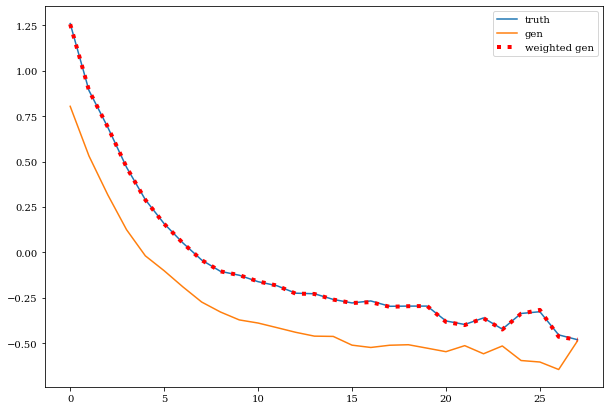

In [110]:
fig, ax = plt.subplots(figsize=(10, 7))


plt.plot(w_avgs_t, label='truth')
plt.plot(w_avgs_g, label='gen')
plt.plot(w_avgs_wg, label='weighted gen', color="r",ls=":", lw=4)
plt.legend()
plt.savefig("pjetmean.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [104]:
w_var_t = [np.var(X_test_particle[Y_test==0][:,0][pTbins_t==i]) for i in range(1, len(p_bins)-1)]
w_var_g = [np.var(X_test_particle[Y_test==1][:,0][pTbins_g==i]) for i in range(1, len(p_bins)-1)]
w_var_wg = [np.cov(X_test_particle[Y_test==0][:,0][pTbins_wg==i], aweights = w_test[Y_test==0][pTbins_wg==i]) for i in range(1, len(p_bins)-1)]

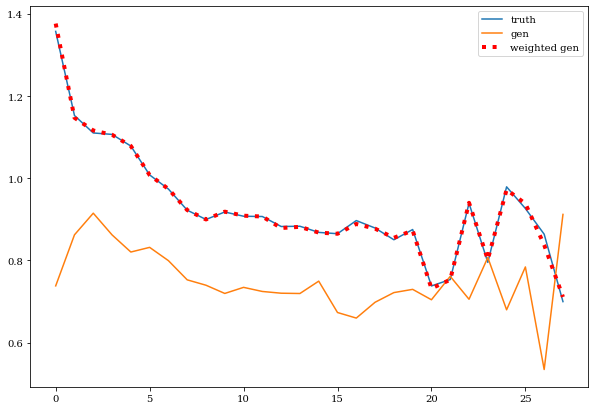

In [112]:
fig, ax = plt.subplots(figsize=(10, 7))


plt.plot(w_var_t, label='truth')
plt.plot(w_var_g, label='gen')
plt.plot(w_var_wg, label='weighted gen', color="r",ls=":", lw=4)
plt.legend()
plt.savefig("pjetvar.pdf", bbox_inches='tight', transparent=True)
plt.show()